# 1. 数据来源及背景
数据来源: http://archive.ics.uci.edu/ml/machine-learning-databases/00292;

数据背景: 这是某批发经销商客户在各类型产品的年度支出数据集. 该数据集样本容量为440, 共有8个特征, 其分别为:客户渠道, 客户所在地区, 以及在新鲜产品, 奶制品, 食品杂货, 冷冻产品, 洗涤剂和纸制品, 熟食产品这6种类型产品的年度支出.

# 2. 明确分析目的
通过提出一系列问题, 明确我们的分析目的:

1) 各类产品的年度支出平均水平如何？哪个产品最高？哪个又最低？

2) 如何对这些客户进行分类呢？他们的消费行为又是怎样的呢？

3) 商家该如何根据分类结果制定营销计划呢？

# 3. 数据探索分析

### 1. 查看前2行和后2行

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('Wholesale customers data.csv')
pd.set_option("display.max_row",4)
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
...,...,...,...,...,...,...,...,...
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


### 2. 查看数据整体信息

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


### 3. 描述性统计

In [3]:
pd.set_option("display.max_row",10)
df.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### 4. 数据预处理

#### 1. 数据清洗

1) 缺失值处理

2) 异常值处理

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
df_index=np.arange(len(df.columns)-2)
fig,ax=plt.subplots(1,6,figsize=(24,4))
for i in df_index:
    sns.boxplot(y=df.columns[i+2],data=df,ax=ax[i])

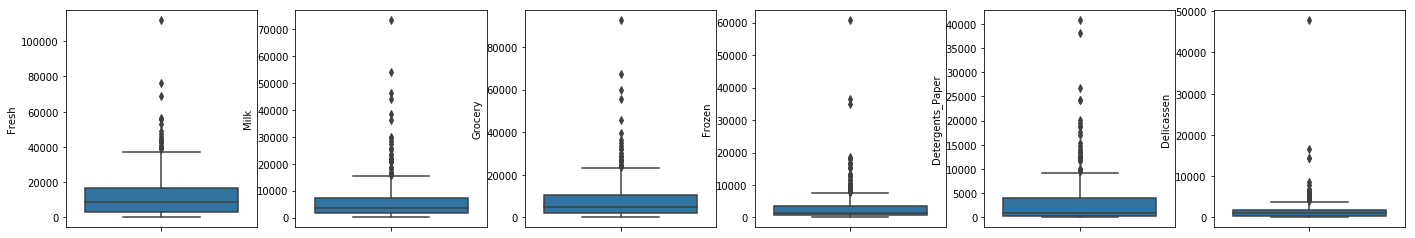

In [5]:
def get_boxplot(data, start, end):
    fig, ax = plt.subplots(1, end-start, figsize=(24, 4))
    for i in range(start, end):
        sns.boxplot(y=data[data.columns[i]], data=data, ax=ax[i-start])
get_boxplot(df, 2, 8)

原有样本容量:440, 剔除后样本容量:318


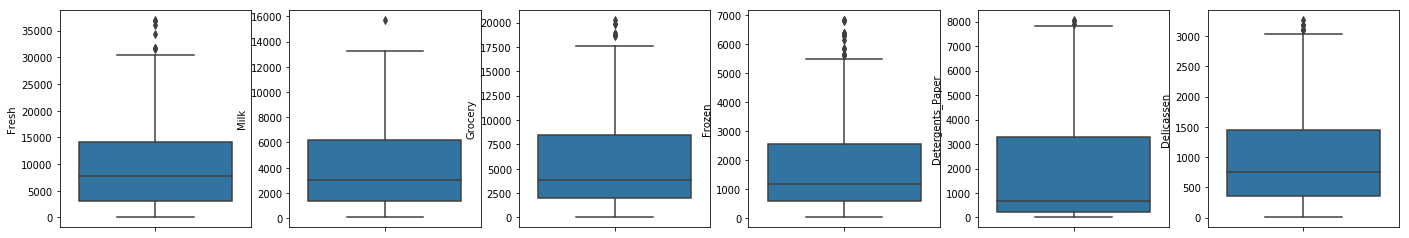

In [6]:
# 可以看到均有不同程度的异常值, 由于k-means算法对异常值较敏感, 选择剔除它
def drop_outlier(data, start, end):
    for i in range(start,end):
        a=data.columns[i]
        Q1=np.quantile(data[a],0.25)
        Q3=np.quantile(data[a],0.75)
        deta = (Q3 - Q1) * 1.5
        data=data[(data[a]>=Q1-deta)&(data[a]<=Q3+deta)]
    return data
del_df = drop_outlier(df, 2, 8)
print("原有样本容量:{0}, 剔除后样本容量:{1}"
      .format(df.shape[0], del_df.shape[0]))
get_boxplot(del_df, 2, 8)

原有样本容量:440, 彻底剔除后样本容量:97


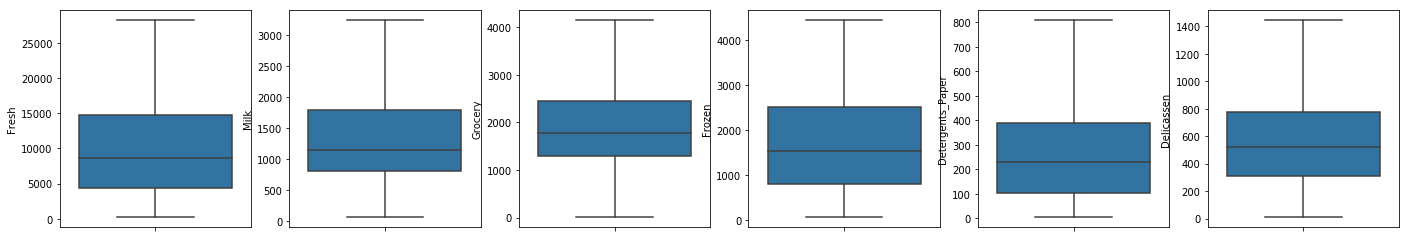

In [7]:
df_new = df.copy()
#直到第10次的时候图像上才没有出现异常值
for i in range(10):
    df_new = drop_outlier(df_new, 2, 8)
print("原有样本容量:{0}, 彻底剔除后样本容量:{1}".format(df.shape[0], df_new.shape[0]))
get_boxplot(df_new, 2, 8)

#### 2. 数据变换

1) 离散型变量

In [8]:
#将离散型变量处理成哑变量
del_df['Channel'] = del_df.Channel.astype(str)
del_df['Region'] = del_df.Region.astype(str)
del_df=pd.get_dummies(del_df)

2) 连续型变量

In [9]:
#z-score进行归一化处理
for i in range(6):
    a=del_df.columns[i]
    del_df[a]=del_df[a].apply(lambda x:(x-del_df[a].mean())/del_df[a].std())

### 5. 构建模型

#### 1. 构建K=2的聚类模型

In [10]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2,random_state=10)
km.fit(del_df)
print(km.cluster_centers_)
print(km.labels_)

[[ 0.05621955 -0.49044518 -0.55531191  0.14445525 -0.55113065 -0.20260137
   0.97260274  0.02739726  0.20091324  0.10502283  0.69406393]
 [-0.12436447  1.0849242   1.22841726 -0.31955252  1.21916781  0.44817879
   0.19191919  0.80808081  0.11111111  0.07070707  0.81818182]]
[1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1
 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0]


#### 2. 迭代选择合适的k值

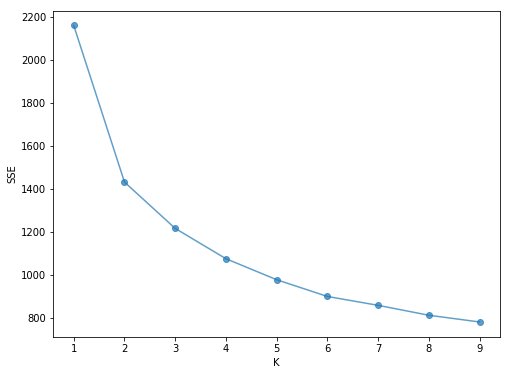

In [11]:
k=range(1,10)
sse = []
for i in k:
    km=KMeans(n_clusters=i,random_state=10)
    km.fit(del_df)
    sse.append(km.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(k, sse, '-o', alpha=0.7)
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()  

选择K=2, 也就是说将客户分成两类

# 6. 客户价值细分

In [12]:
from pandas.plotting import parallel_coordinates
#训练模型
km = KMeans(n_clusters=2, random_state=10)
km.fit(del_df)
centers = km.cluster_centers_ 
labels =  km.labels_
customer = pd.DataFrame({'0': centers[0], "1": centers[1],'2': del_df.median()}).T
customer.columns = del_df.keys()
customer["category"] = ["customer_1", "customer_2", 'median']
#绘制图像
customer

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,category
0,0.056220,-0.490445,-0.555312,0.144455,-0.551131,-0.202601,0.972603,0.027397,0.200913,0.105023,0.694064,customer_1
1,-0.124364,1.084924,1.228417,-0.319553,1.219168,0.448179,0.191919,0.808081,0.111111,0.070707,0.818182,customer_2
2,-0.233737,-0.289572,-0.378143,-0.375251,-0.528233,-0.303265,1.000000,0.000000,0.000000,0.000000,1.000000,median


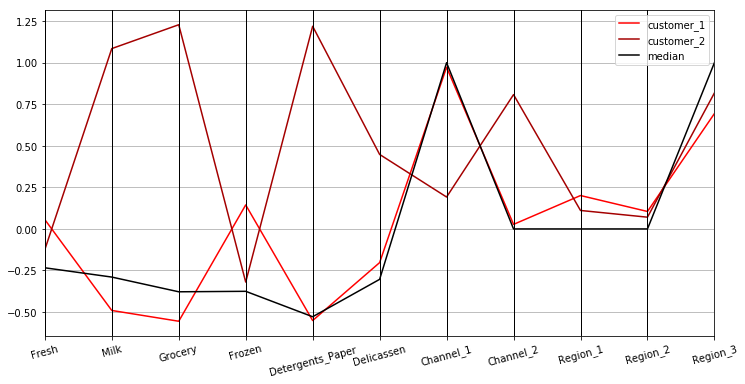

In [13]:
plt.figure(figsize=(12, 6))
parallel_coordinates(customer,"category",colormap="flag")
plt.xticks(rotation = 15)
plt.show()

我们通过k-means聚类模型将这些客户分为两群: 客户群1和客户群2.
就六种类型产品的年度支出来看, 客户群1在冷冻产品上最高, 在洗涤剂和纸制品上最低; 客户群2在冷冻产品上则最低, 在洗涤剂和纸制品上则最高. 另外, 客户群2在这六种产品的年度支出聚类中心均位于中位数水平之上上, 因此可将客户群2视为重要价值客户, 而客户群1则为一般价值客户.

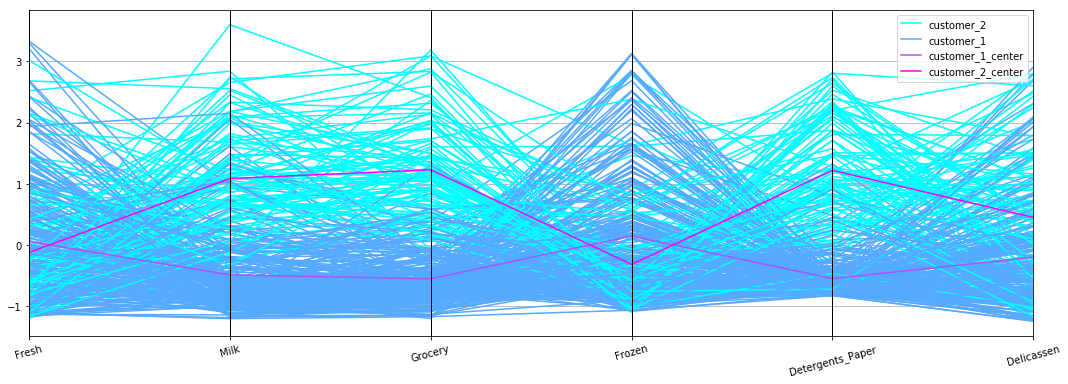

In [14]:
#将聚类后的标签加入数据集
del_df["category"]=labels
del_df["category"]=np.where(del_df.category == 0, 'customer_1', 'customer_2')
customer = pd.DataFrame({'0': centers[0], "1": centers[1]}).T
customer["category"] = ['customer_1_center', "customer_2_center"]
customer.columns = del_df.keys()
del_df=pd.concat([del_df, customer])
#对6类产品每年消费水平进行绘制图像
df_new = del_df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'category']]
plt.figure(figsize=(18, 6))
parallel_coordinates(df_new, "category", colormap='cool')
plt.xticks(rotation = 15)
plt.show()

就六大类型产品来说, 可通过问卷的方式来调研改善店铺内布局以及增加产品种类是否会影响客户的购买行为; 另外, 根据聚类结果发现高价值客户的来源倾向于渠道2, 可加大在该渠道上的宣传力度; 最后,可进行一些打折促销活动，刺激客户的购买行为.
https://www.cnblogs.com/star-zhao/p/10209333.html